# Caribbean Voices ASR - Data Exploration

**Competition**: Zindi Caribbean Voices Hackathon  
**Objective**: Explore the training data to understand audio characteristics, transcription patterns, and data quality  
**Author**: Team SMG Labs  
**Date**: November 20, 2024

## Notebook Overview

This notebook explores:
1. Dataset statistics and structure
2. Audio file characteristics (duration, sample rate, quality)
3. Transcription analysis (length, vocabulary, patterns)
4. Data quality assessment
5. Recommendations for preprocessing and splitting

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import librosa
import soundfile as sf
from tqdm.auto import tqdm
import warnings
from collections import Counter
import re

warnings.filterwarnings('ignore')

# Set style
sns.set_theme(style='darkgrid', palette='husl')
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)

c:\Users\Heidi\OneDrive\Desktop\Projects\smg_labs\caribbean-asr-hackathon\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define paths
PROJECT_ROOT = Path.cwd().parent.parent
DATA_DIR = PROJECT_ROOT / 'data' / 'raw'
AUDIO_DIR = DATA_DIR / 'Audio'

TRAIN_CSV = DATA_DIR / 'Train.csv'
TEST_CSV = DATA_DIR / 'Test.csv'
SAMPLE_SUB = DATA_DIR / 'SampleSubmission.csv'

print(f"Project Root: {PROJECT_ROOT}")
print(f"Data Directory: {DATA_DIR}")
print(f"Audio Directory: {AUDIO_DIR}")
print(f"\nFiles exist:")
print(f"  Train.csv: {TRAIN_CSV.exists()}")
print(f"  Test.csv: {TEST_CSV.exists()}")
print(f"  Audio folder: {AUDIO_DIR.exists()}")

Project Root: c:\Users\Heidi\OneDrive\Desktop\Projects\smg_labs\caribbean-asr-hackathon
Data Directory: c:\Users\Heidi\OneDrive\Desktop\Projects\smg_labs\caribbean-asr-hackathon\data\raw
Audio Directory: c:\Users\Heidi\OneDrive\Desktop\Projects\smg_labs\caribbean-asr-hackathon\data\raw\Audio

Files exist:
  Train.csv: True
  Test.csv: True
  Audio folder: True


## 2. Load Data

In [3]:
# Load CSV files
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)
sample_sub = pd.read_csv(SAMPLE_SUB)

print(f"Training samples: {len(train_df):,}")
print(f"Test samples: {len(test_df):,}")
print(f"\nTrain columns: {train_df.columns.tolist()}")
print(f"Test columns: {test_df.columns.tolist()}")

Training samples: 19,856
Test samples: 8,510

Train columns: ['ID', 'Transcription']
Test columns: ['ID']


In [4]:
# Display first few rows
print("=" * 80)
print("TRAINING DATA SAMPLE")
print("=" * 80)
train_df.head(10)

TRAINING DATA SAMPLE


,ID,Transcription
0,ID_YIKKFU,She says that victims of racism around the wor...
1,ID_EUZHDE,"From London, BBC Caribbean Report."
2,ID_EGMNXY,"First of all, our visitors have suffered incon..."
3,ID_UIDAQV,Prime Minister Owen Arthur describing American...
4,ID_YDUVSM,Secretary General Edwin Carrington said this w...
5,ID_UNDHGW,Lucia Prime Minister Sir John Compton says he ...
6,ID_NMMSMI,"From London, this is BBC Caribbean Report."
7,ID_PWETSO,"However, this does provide an opportunity to h..."
8,ID_JIAYLD,I think that the attempts by the Clinton admin...
9,ID_EKHUSL,"But who's to say, Demi Eugenia, that the Archb..."


In [6]:
# Check for missing values
print("Missing values in training data:")
print(train_df.isnull().sum())
print(f"\nRows with missing transcriptions: {train_df['Transcription'].isnull().sum()}")

Missing values in training data:
ID               0
Transcription    0
dtype: int64

Rows with missing transcriptions: 0


## 3. Audio File Analysis

In [7]:
# Count audio files
audio_files = list(AUDIO_DIR.glob('*.wav'))
print(f"Total audio files: {len(audio_files):,}")
print(f"Expected (train + test): {len(train_df) + len(test_df):,}")
print(f"\nSample audio filenames:")
for f in audio_files[:5]:
    print(f"  {f.name}")

Total audio files: 28,367
Expected (train + test): 28,366

Sample audio filenames:
  ID_AABYXM.wav
  ID_AACPZT.wav
  ID_AADAVI.wav
  ID_AADFAI.wav
  ID_AAEVCO.wav


In [10]:
# Verify all training audio files exist
missing_files = []
for audio_id in train_df['ID']:
    audio_path = AUDIO_DIR / f"{audio_id}.wav"
    if not audio_path.exists():
        missing_files.append(audio_id)

print(f"Missing audio files in training set: {len(missing_files)}")
if missing_files:
    print(f"First few missing: {missing_files[:5]}")

Missing audio files in training set: 0


### 3.1 Sample Audio Files for Detailed Analysis

In [11]:
# Sample a subset for detailed audio analysis (to save time)
SAMPLE_SIZE = 500  # Adjust based on your needs
sample_indices = np.random.choice(len(train_df), size=min(SAMPLE_SIZE, len(train_df)), replace=False)
sample_df = train_df.iloc[sample_indices].copy()

print(f"Analyzing {len(sample_df)} sampled audio files...")

Analyzing 500 sampled audio files...


In [15]:
# Extract audio characteristics
def get_audio_info(audio_id):
    """Extract audio file metadata and characteristics."""
    audio_path = AUDIO_DIR / f"{audio_id}.wav"
    
    try:
        # Get basic info using soundfile (faster)
        info = sf.info(audio_path)
        duration = info.duration
        sample_rate = info.samplerate
        channels = info.channels
        
        # Load audio for additional analysis
        audio, sr = librosa.load(audio_path, sr=None)
        
        # Calculate additional features
        rms_energy = np.sqrt(np.mean(audio**2))
        zero_crossing_rate = np.mean(librosa.zero_crossings(audio))
        
        return {
            'duration': duration,
            'sample_rate': sample_rate,
            'channels': channels,
            'rms_energy': rms_energy,
            'zero_crossing_rate': zero_crossing_rate,
            'file_exists': True
        }
    except Exception as e:
        return {
            'duration': None,
            'sample_rate': None,
            'channels': None,
            'rms_energy': None,
            'zero_crossing_rate': None,
            'file_exists': False,
            'error': str(e)
        }

# Process sample
audio_info_list = []
for audio_id in tqdm(sample_df['ID'], desc="Analyzing audio files"):
    info = get_audio_info(audio_id)
    info['audio_id'] = audio_id
    audio_info_list.append(info)

audio_info_df = pd.DataFrame(audio_info_list)
sample_df = sample_df.merge(audio_info_df, left_on='ID', right_on='audio_id')

Analyzing audio files: 100%|██████████| 500/500 [00:00<00:00, 650.83it/s]


In [16]:
# Audio statistics
print("=" * 80)
print("AUDIO CHARACTERISTICS (from sample)")
print("=" * 80)
print(f"\nDuration (seconds):")
print(sample_df['duration'].describe())
print(f"\nSample Rates:")
print(sample_df['sample_rate'].value_counts())
print(f"\nChannels:")
print(sample_df['channels'].value_counts())
print(f"\nRMS Energy:")
print(sample_df['rms_energy'].describe())

AUDIO CHARACTERISTICS (from sample)

Duration (seconds):
count    500.000000
mean       5.906360
std        2.995872
min        2.001000
25%        3.580250
50%        5.263000
75%        7.447000
max       19.174000
Name: duration, dtype: float64

Sample Rates:
sample_rate
16000    500
Name: count, dtype: int64

Channels:
channels
1    500
Name: count, dtype: int64

RMS Energy:
count    500.000000
mean       0.100610
std        0.027450
min        0.029122
25%        0.083181
50%        0.098750
75%        0.116327
max        0.255548
Name: rms_energy, dtype: float64


### 3.2 Audio Duration Visualization

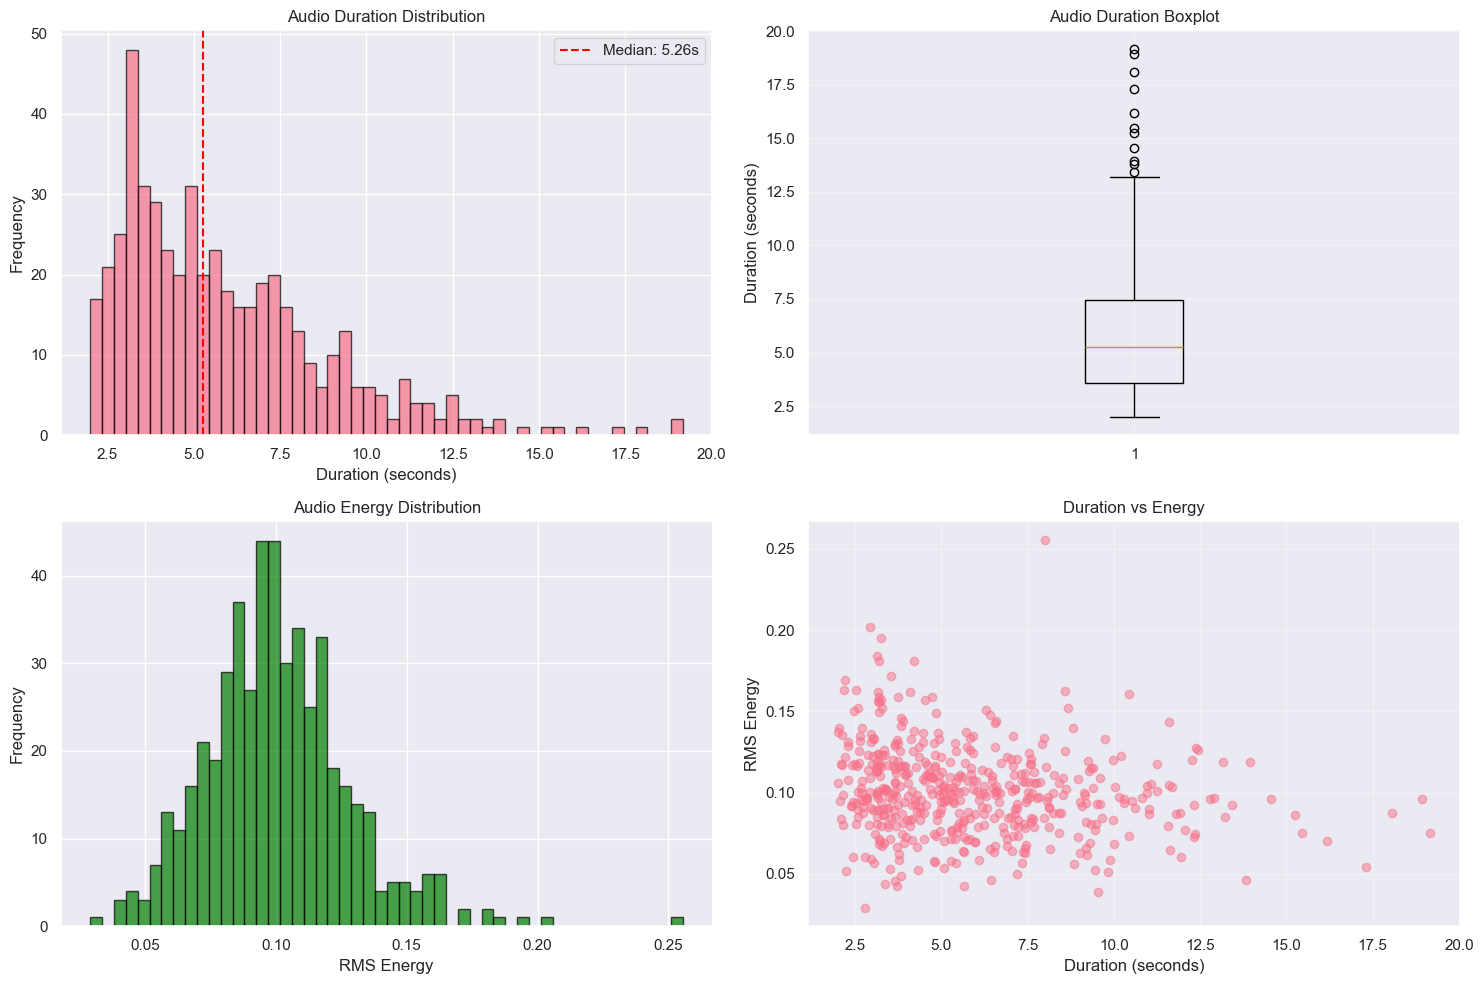

In [17]:
# Plot duration distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Duration histogram
axes[0, 0].hist(sample_df['duration'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Duration (seconds)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Audio Duration Distribution')
axes[0, 0].axvline(sample_df['duration'].median(), color='red', linestyle='--', label=f'Median: {sample_df["duration"].median():.2f}s')
axes[0, 0].legend()

# Duration boxplot
axes[0, 1].boxplot(sample_df['duration'].dropna(), vert=True)
axes[0, 1].set_ylabel('Duration (seconds)')
axes[0, 1].set_title('Audio Duration Boxplot')
axes[0, 1].grid(True, alpha=0.3)

# RMS Energy distribution
axes[1, 0].hist(sample_df['rms_energy'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].set_xlabel('RMS Energy')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Audio Energy Distribution')

# Duration vs Energy scatter
axes[1, 1].scatter(sample_df['duration'], sample_df['rms_energy'], alpha=0.5)
axes[1, 1].set_xlabel('Duration (seconds)')
axes[1, 1].set_ylabel('RMS Energy')
axes[1, 1].set_title('Duration vs Energy')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Transcription Analysis

In [19]:
# Add transcription length features
train_df['transcription_length'] = train_df['Transcription'].str.len()
train_df['word_count'] = train_df['Transcription'].str.split().str.len()
train_df['avg_word_length'] = train_df['transcription_length'] / train_df['word_count']

print("=" * 80)
print("TRANSCRIPTION STATISTICS")
print("=" * 80)
print(f"\nCharacter length:")
print(train_df['transcription_length'].describe())
print(f"\nWord count:")
print(train_df['word_count'].describe())
print(f"\nAverage word length:")
print(train_df['avg_word_length'].describe())

TRANSCRIPTION STATISTICS

Character length:
count    19856.000000
mean       104.730560
std         56.128128
min          5.000000
25%         61.000000
50%         95.000000
75%        135.000000
max        798.000000
Name: transcription_length, dtype: float64

Word count:
count    19856.000000
mean        17.564363
std          9.502703
min          1.000000
25%         10.000000
50%         16.000000
75%         22.000000
max        186.000000
Name: word_count, dtype: float64

Average word length:
count    19856.000000
mean         6.009813
std          0.707497
min          3.714286
25%          5.531749
50%          5.950000
75%          6.466667
max         10.250000
Name: avg_word_length, dtype: float64


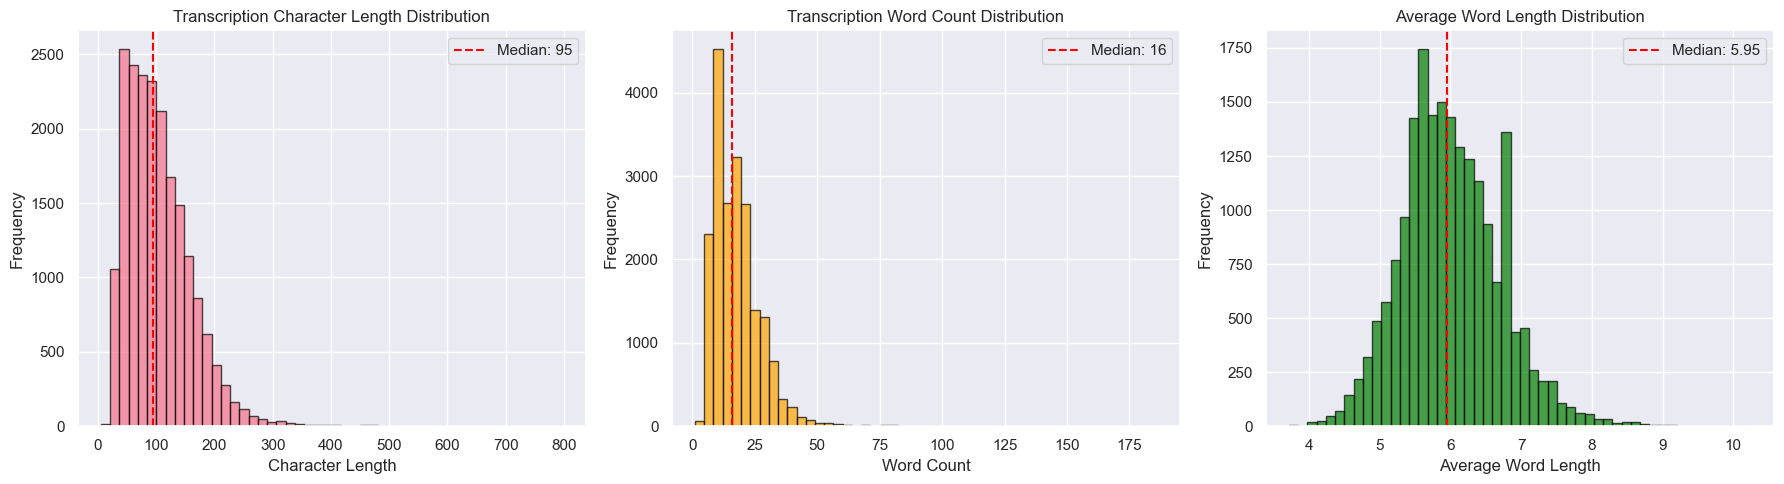

In [20]:
# Visualize transcription statistics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Character length distribution
axes[0].hist(train_df['transcription_length'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Character Length')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Transcription Character Length Distribution')
axes[0].axvline(train_df['transcription_length'].median(), color='red', linestyle='--', 
                label=f'Median: {train_df["transcription_length"].median():.0f}')
axes[0].legend()

# Word count distribution
axes[1].hist(train_df['word_count'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Transcription Word Count Distribution')
axes[1].axvline(train_df['word_count'].median(), color='red', linestyle='--', 
                label=f'Median: {train_df["word_count"].median():.0f}')
axes[1].legend()

# Average word length distribution
axes[2].hist(train_df['avg_word_length'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[2].set_xlabel('Average Word Length')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Average Word Length Distribution')
axes[2].axvline(train_df['avg_word_length'].median(), color='red', linestyle='--', 
                label=f'Median: {train_df["avg_word_length"].median():.2f}')
axes[2].legend()

plt.tight_layout()
plt.show()

### 4.1 Vocabulary Analysis

In [21]:
# Build vocabulary
all_words = []
for text in train_df['Transcription']:
    if pd.notna(text):
        words = text.lower().split()
        all_words.extend(words)

word_counts = Counter(all_words)
vocab_size = len(word_counts)

print(f"Total words (tokens): {len(all_words):,}")
print(f"Unique words (vocabulary size): {vocab_size:,}")
print(f"\nTop 20 most common words:")
for word, count in word_counts.most_common(20):
    print(f"  {word:20s}: {count:6,} ({count/len(all_words)*100:.2f}%)")

Total words (tokens): 348,758
Unique words (vocabulary size): 24,242

Top 20 most common words:
  the                 : 25,466 (7.30%)
  of                  : 10,810 (3.10%)
  to                  : 10,559 (3.03%)
  and                 :  9,253 (2.65%)
  in                  :  7,670 (2.20%)
  a                   :  7,002 (2.01%)
  that                :  4,990 (1.43%)
  is                  :  4,933 (1.41%)
  caribbean           :  3,421 (0.98%)
  for                 :  3,361 (0.96%)
  on                  :  2,746 (0.79%)
  this                :  2,716 (0.78%)
  from                :  2,458 (0.70%)
  have                :  2,192 (0.63%)
  with                :  2,175 (0.62%)
  bbc                 :  2,167 (0.62%)
  be                  :  2,147 (0.62%)
  as                  :  2,116 (0.61%)
  report.             :  2,071 (0.59%)
  are                 :  1,911 (0.55%)


In [22]:
# Character-level analysis
all_chars = ''.join(train_df['Transcription'].dropna())
char_counts = Counter(all_chars)

print(f"Total characters: {len(all_chars):,}")
print(f"Unique characters: {len(char_counts)}")
print(f"\nCharacter set:")
print(''.join(sorted(char_counts.keys())))
print(f"\nTop 20 most common characters:")
for char, count in char_counts.most_common(20):
    display_char = repr(char) if char in [' ', '\n', '\t'] else char
    print(f"  {display_char:10s}: {count:8,} ({count/len(all_chars)*100:.2f}%)")

Total characters: 2,079,530
Unique characters: 74

Character set:
 "&',-.?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz£Éáçèéíïñóöęł€

Top 20 most common characters:
  ' '       :  328,902 (15.82%)
  e         :  204,318 (9.83%)
  t         :  157,227 (7.56%)
  a         :  139,983 (6.73%)
  n         :  130,784 (6.29%)
  i         :  129,213 (6.21%)
  o         :  127,063 (6.11%)
  r         :  107,673 (5.18%)
  s         :  103,238 (4.96%)
  h         :   76,696 (3.69%)
  l         :   58,183 (2.80%)
  d         :   57,777 (2.78%)
  c         :   44,845 (2.16%)
  m         :   39,970 (1.92%)
  u         :   39,543 (1.90%)
  p         :   32,963 (1.59%)
  f         :   32,366 (1.56%)
  g         :   31,127 (1.50%)
  b         :   28,745 (1.38%)
  y         :   24,935 (1.20%)


In [24]:
# Check for special characters and patterns
special_patterns = {
    'Numbers': r'\d',
    'Punctuation': r'[.,!?;:\'"()-]',
    'Uppercase': r'[A-Z]',
    'Special chars': r'[^a-zA-Z0-9\s.,!?;:\'"()-]'
}

print("=" * 80)
print("SPECIAL CHARACTER PATTERNS")
print("=" * 80)
for pattern_name, pattern in special_patterns.items():
    count = train_df['Transcription'].str.contains(pattern, regex=True, na=False).sum()
    pct = count / len(train_df) * 100
    print(f"{pattern_name:20s}: {count:6,} samples ({pct:5.2f}%)")

SPECIAL CHARACTER PATTERNS
Numbers             :      0 samples ( 0.00%)
Punctuation         : 19,539 samples (98.40%)
Uppercase           : 19,264 samples (97.02%)
Special chars       :    130 samples ( 0.65%)


### 4.2 Sample Transcriptions

In [25]:
# Show random sample of transcriptions
print("=" * 80)
print("RANDOM TRANSCRIPTION SAMPLES")
print("=" * 80)
for i, row in train_df.sample(10).iterrows():
    print(f"\n[{row['ID']}]")
    print(f"  {row['Transcription']}")
    print(f"  (Length: {row['transcription_length']} chars, {row['word_count']} words)")

RANDOM TRANSCRIPTION SAMPLES

[ID_LCJFOO]
  CARICOM governments meet in a month to consider setting up a regional appeal court.
  (Length: 83 chars, 14 words)

[ID_JEBWIV]
  And he will no doubt make the results known in due course.
  (Length: 58 chars, 12 words)

[ID_QFUNZJ]
  As Eddie Williams reports, Dutch Saint Martin is now hoping to access CARICOM's foreign policy outlets to air its grievances.
  (Length: 125 chars, 20 words)

[ID_SCZJTA]
  Third world countries are to be hit as Britain blocks European development efforts in the fight over beef.
  (Length: 106 chars, 18 words)

[ID_TPMVTE]
  Well, this is really absolutely true, and this is the predicament that we are faced with in the University of the West Indies, which has been the main vehicle at the upper end of the tertiary sector.
  (Length: 199 chars, 37 words)

[ID_WOWUJJ]
  should be engaged and that it would be a free and fair trial this trial we we were satisfied is a trial by civilian judges we were a little concern

## 5. Audio-Transcription Correlation

In [28]:
# Merge word count from train_df to sample_df
# First, ensure sample_df has the word_count column from train_df
sample_df = sample_df.merge(train_df[['ID', 'word_count']], on='ID', how='left', suffixes=('', '_y'))
# Drop duplicate column if it exists
if 'word_count_y' in sample_df.columns:
    sample_df = sample_df.drop(columns=['word_count_y'])

# Calculate speech rate (words per second) for sample
sample_df['speech_rate'] = sample_df['word_count'] / sample_df['duration']

print("=" * 80)
print("SPEECH RATE ANALYSIS (from sample)")
print("=" * 80)
print(sample_df['speech_rate'].describe())

SPEECH RATE ANALYSIS (from sample)
count    500.000000
mean       2.948794
std        0.581703
min        1.342482
25%        2.607365
50%        2.959535
75%        3.295185
max        5.028098
Name: speech_rate, dtype: float64


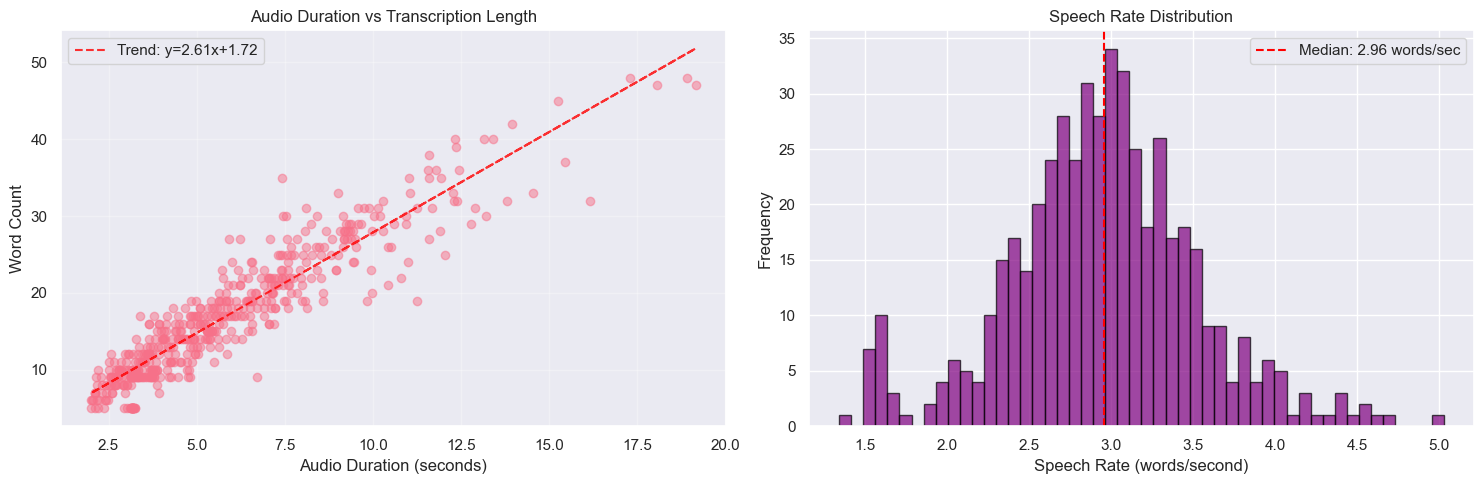

In [29]:
# Visualize audio-transcription relationships
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Duration vs word count
axes[0].scatter(sample_df['duration'], sample_df['word_count'], alpha=0.5)
axes[0].set_xlabel('Audio Duration (seconds)')
axes[0].set_ylabel('Word Count')
axes[0].set_title('Audio Duration vs Transcription Length')
axes[0].grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(sample_df['duration'].dropna(), sample_df['word_count'].dropna(), 1)
p = np.poly1d(z)
axes[0].plot(sample_df['duration'].dropna(), p(sample_df['duration'].dropna()), 
             "r--", alpha=0.8, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
axes[0].legend()

# Speech rate distribution
axes[1].hist(sample_df['speech_rate'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[1].set_xlabel('Speech Rate (words/second)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Speech Rate Distribution')
axes[1].axvline(sample_df['speech_rate'].median(), color='red', linestyle='--', 
                label=f'Median: {sample_df["speech_rate"].median():.2f} words/sec')
axes[1].legend()

plt.tight_layout()
plt.show()

## 6. Data Quality Assessment

In [32]:
# Identify potential quality issues
print("=" * 80)
print("DATA QUALITY CHECKS")
print("=" * 80)

# Very short transcriptions
very_short = train_df[train_df['word_count'] < 3]
print(f"\nVery short transcriptions (<3 words): {len(very_short)} ({len(very_short)/len(train_df)*100:.2f}%)")
if len(very_short) > 0:
    print("Examples:")
    for _, row in very_short.head(5).iterrows():
        print(f"  [{row['ID']}]: '{row['Transcription']}'")

# Very long transcriptions
very_long = train_df[train_df['word_count'] > train_df['word_count'].quantile(0.99)]
print(f"\nVery long transcriptions (>99th percentile): {len(very_long)} ({len(very_long)/len(train_df)*100:.2f}%)")
print(f"99th percentile word count: {train_df['word_count'].quantile(0.99):.0f} words")

# Empty or null transcriptions
empty_trans = train_df[train_df['Transcription'].isna() | (train_df['Transcription'].str.strip() == '')]
print(f"\nEmpty/null transcriptions: {len(empty_trans)}")

# Duplicate transcriptions
duplicate_trans = train_df[train_df.duplicated(subset=['Transcription'], keep=False)]
print(f"\nDuplicate transcriptions: {len(duplicate_trans)} ({len(duplicate_trans)/len(train_df)*100:.2f}%)")
print(f"Unique duplicated texts: {duplicate_trans['Transcription'].nunique()}")

DATA QUALITY CHECKS

Very short transcriptions (<3 words): 6 (0.03%)
Examples:
  [ID_RBVWAJ]: 'MUSIC'
  [ID_FRJFSY]: 'Wars despising'
  [ID_NHYBEF]: 'Music'
  [ID_REEKCW]: 'It's there.'
  [ID_JRCPGX]: 'today.'

Very long transcriptions (>99th percentile): 185 (0.93%)
99th percentile word count: 48 words

Empty/null transcriptions: 0

Duplicate transcriptions: 2016 (10.15%)
Unique duplicated texts: 98


In [33]:
# Audio quality issues (from sample)
print("=" * 80)
print("AUDIO QUALITY CHECKS (from sample)")
print("=" * 80)

# Very short audio
very_short_audio = sample_df[sample_df['duration'] < 1.0]
print(f"\nVery short audio (<1 second): {len(very_short_audio)} ({len(very_short_audio)/len(sample_df)*100:.2f}%)")

# Very long audio
very_long_audio = sample_df[sample_df['duration'] > sample_df['duration'].quantile(0.99)]
print(f"Very long audio (>99th percentile): {len(very_long_audio)} ({len(very_long_audio)/len(sample_df)*100:.2f}%)")
print(f"99th percentile duration: {sample_df['duration'].quantile(0.99):.2f} seconds")

# Low energy (potential silence/noise)
low_energy_threshold = sample_df['rms_energy'].quantile(0.05)
low_energy = sample_df[sample_df['rms_energy'] < low_energy_threshold]
print(f"\nLow energy audio (<5th percentile): {len(low_energy)} ({len(low_energy)/len(sample_df)*100:.2f}%)")
print(f"5th percentile RMS energy: {low_energy_threshold:.6f}")

# Unusual speech rates
unusual_rate = sample_df[
    (sample_df['speech_rate'] < sample_df['speech_rate'].quantile(0.01)) |
    (sample_df['speech_rate'] > sample_df['speech_rate'].quantile(0.99))
]
print(f"\nUnusual speech rates (outside 1st-99th percentile): {len(unusual_rate)} ({len(unusual_rate)/len(sample_df)*100:.2f}%)")

AUDIO QUALITY CHECKS (from sample)

Very short audio (<1 second): 0 (0.00%)
Very long audio (>99th percentile): 5 (1.00%)
99th percentile duration: 15.47 seconds

Low energy audio (<5th percentile): 25 (5.00%)
5th percentile RMS energy: 0.058812

Unusual speech rates (outside 1st-99th percentile): 10 (2.00%)


## 7. Recommendations for Data Splitting

In [34]:
# Analyze distribution for stratification
# Create duration bins for stratification
sample_df['duration_bin'] = pd.cut(sample_df['duration'], bins=5, labels=['very_short', 'short', 'medium', 'long', 'very_long'])
sample_df['word_count_bin'] = pd.cut(sample_df['word_count'], bins=5, labels=['very_few', 'few', 'medium', 'many', 'very_many'])

print("=" * 80)
print("STRATIFICATION ANALYSIS (from sample)")
print("=" * 80)
print("\nDuration bins:")
print(sample_df['duration_bin'].value_counts().sort_index())
print("\nWord count bins:")
print(sample_df['word_count_bin'].value_counts().sort_index())

STRATIFICATION ANALYSIS (from sample)

Duration bins:
duration_bin
very_short    265
short         156
medium         59
long           15
very_long       5
Name: count, dtype: int64

Word count bins:
word_count_bin
very_few     192
few          191
medium        81
many          27
very_many      9
Name: count, dtype: int64


## 8. Summary and Recommendations

In [36]:
print("=" * 80)
print("DATA EXPLORATION SUMMARY")
print("=" * 80)

print(f"""
DATASET OVERVIEW:
  - Training samples: {len(train_df):,}
  - Test samples: {len(test_df):,}
  - Total audio files: {len(audio_files):,}

AUDIO CHARACTERISTICS (from {len(sample_df)} samples):
  - Duration range: {sample_df['duration'].min():.2f}s - {sample_df['duration'].max():.2f}s
  - Median duration: {sample_df['duration'].median():.2f}s
  - Sample rate: {sample_df['sample_rate'].mode().values[0] if len(sample_df['sample_rate'].mode()) > 0 else 'N/A'} Hz (most common)
  - Channels: {sample_df['channels'].mode().values[0] if len(sample_df['channels'].mode()) > 0 else 'N/A'} (most common)

TRANSCRIPTION CHARACTERISTICS:
  - Vocabulary size: {vocab_size:,} unique words
  - Character set size: {len(char_counts)} unique characters
  - Median word count: {train_df['word_count'].median():.0f} words
  - Median character length: {train_df['transcription_length'].median():.0f} characters
  - Speech rate (median): {sample_df['speech_rate'].median():.2f} words/second

DATA QUALITY:
  - Missing transcriptions: {train_df['Transcription'].isna().sum()}
  - Very short transcriptions (<3 words): {len(very_short)} ({len(very_short)/len(train_df)*100:.2f}%)
  - Duplicate transcriptions: {len(duplicate_trans)} ({len(duplicate_trans)/len(train_df)*100:.2f}%)

RECOMMENDATIONS:

1. PREPROCESSING:
   - Standardize sample rate to {sample_df['sample_rate'].mode().values[0] if len(sample_df['sample_rate'].mode()) > 0 else '16000'} Hz
   - Convert to mono if needed (channels: {sample_df['channels'].mode().values[0] if len(sample_df['channels'].mode()) > 0 else '1'})
   - Consider noise reduction for low-energy samples
   - Normalize text (lowercase, punctuation handling)

2. DATA SPLITTING:
   - Use stratified split based on duration and word count bins
   - Recommended split: 80% train / 15% val / 5% holdout
   - Ensure balanced distribution across bins

3. MODEL CONSIDERATIONS:
   - Whisper models are pre-trained on diverse accents - good starting point
   - Fine-tune on Caribbean accent data
   - Consider data augmentation (speed, pitch, noise)
   - Monitor performance on different duration/length bins

4. NEXT STEPS:
   - Run baseline Whisper model (zero-shot)
   - Create stratified train/val/holdout splits
   - Implement preprocessing pipeline
   - Start fine-tuning experiments
""")

DATA EXPLORATION SUMMARY

DATASET OVERVIEW:
  - Training samples: 19,856
  - Test samples: 8,510
  - Total audio files: 28,367

AUDIO CHARACTERISTICS (from 500 samples):
  - Duration range: 2.00s - 19.17s
  - Median duration: 5.26s
  - Sample rate: 16000 Hz (most common)
  - Channels: 1 (most common)

TRANSCRIPTION CHARACTERISTICS:
  - Vocabulary size: 24,242 unique words
  - Character set size: 74 unique characters
  - Median word count: 16 words
  - Median character length: 95 characters
  - Speech rate (median): 2.96 words/second

DATA QUALITY:
  - Missing transcriptions: 0
  - Very short transcriptions (<3 words): 6 (0.03%)
  - Duplicate transcriptions: 2016 (10.15%)

RECOMMENDATIONS:

1. PREPROCESSING:
   - Standardize sample rate to 16000 Hz
   - Convert to mono if needed (channels: 1)
   - Consider noise reduction for low-energy samples
   - Normalize text (lowercase, punctuation handling)

2. DATA SPLITTING:
   - Use stratified split based on duration and word count bins
   - R

## 9. Export Analysis Results

In [37]:
# Save enhanced dataframes for future use
output_dir = PROJECT_ROOT / 'data' / 'processed'
output_dir.mkdir(exist_ok=True, parents=True)

# Save training data with added features
train_df.to_csv(output_dir / 'train_with_features.csv', index=False)
print(f"Saved enhanced training data to: {output_dir / 'train_with_features.csv'}")

# Save sample audio analysis
sample_df.to_csv(output_dir / 'audio_analysis_sample.csv', index=False)
print(f"Saved audio analysis sample to: {output_dir / 'audio_analysis_sample.csv'}")

# Save vocabulary
vocab_df = pd.DataFrame(word_counts.most_common(), columns=['word', 'count'])
vocab_df.to_csv(output_dir / 'vocabulary.csv', index=False)
print(f"Saved vocabulary to: {output_dir / 'vocabulary.csv'}")

print("\n✅ Data exploration complete!")

Saved enhanced training data to: c:\Users\Heidi\OneDrive\Desktop\Projects\smg_labs\caribbean-asr-hackathon\data\processed\train_with_features.csv
Saved audio analysis sample to: c:\Users\Heidi\OneDrive\Desktop\Projects\smg_labs\caribbean-asr-hackathon\data\processed\audio_analysis_sample.csv
Saved vocabulary to: c:\Users\Heidi\OneDrive\Desktop\Projects\smg_labs\caribbean-asr-hackathon\data\processed\vocabulary.csv

✅ Data exploration complete!
